In [1]:
import os
import pickle

import numpy as np
import numpy.typing as npt
import torch
from torch import Tensor

from autoencoders import DenseAutoencoder, LinearAutoencoder
from scm.box import BoxSCM

import utils

In [2]:
data_dir = "_data1"
latent_dim = 16

In [3]:
# Load data generation config
with open(
    os.path.join(data_dir, "generate_data_cfg.pkl"),
    "rb", pickle.HIGHEST_PROTOCOL
) as f:
    data = pickle.load(f)

num_balls: int = data["num_balls"]
n: int = data["n"]
degree: int = data["degree"]
box_size: int = data["box_size"]
intervention_order: npt.NDArray[np.int_] = data["intervention_order"]
n_samples: int = data["n_samples"]
width: int = data["width"]
height: int = data["height"]
ball_radius: int = data["ball_radius"]
# data_dir = data["data_dir"]  # DON'T!! we are supplying this
scm: BoxSCM = data["scm"]

# Ground truth graph
# Note the permutation by the intervention order
dag_gt = scm.adj_mat
dag_gt = dag_gt[intervention_order, :][:, intervention_order]

# Load z and x data
data = np.load(os.path.join(data_dir, "z_and_x.npz"))
zs_obs = data["zs_obs"]
xs_obs = data["xs_obs"]
zs_obs = torch.from_numpy(zs_obs).float()
xs_obs = torch.from_numpy(xs_obs).float().moveaxis(-1, -3) / 255.0
print(f"Loaded z and x data.")
print(f"{zs_obs.shape = }, {xs_obs.shape = }")

Loaded z and x data.
zs_obs.shape = torch.Size([10000, 6]), xs_obs.shape = torch.Size([10000, 3, 64, 64])


In [4]:
# Load the trained autoencoder step 1
autoenc1 = DenseAutoencoder(latent_dim)
autoenc1.load_state_dict(torch.load(os.path.join(data_dir, f"autoenc_reconstruct_{latent_dim}.pth"), weights_only=True))
autoenc1.requires_grad_(False)

encoder1 = autoenc1.get_submodule("encoder").requires_grad_(False)
decoder1 = autoenc1.get_submodule("decoder").requires_grad_(False)

In [ ]:
# Load the trained autoencoder step 2
autoenc2 = LinearAutoencoder(n, latent_dim)
autoenc2.load_state_dict(torch.load(os.path.join(data_dir, f"autoenc_disentangle_{latent_dim}.pth"), weights_only=True))
autoenc2.requires_grad_(False)

encoder2 = autoenc2.get_submodule("encoder").requires_grad_(False)
decoder2 = autoenc2.get_submodule("decoder").requires_grad_(False)

In [6]:
encoder = torch.nn.Sequential(encoder1, encoder2)
decoder = torch.nn.Sequential(decoder2, decoder1)

In [7]:
### Part 2: Analysis

## Latent variables recovery
# Mean correlation coefficient
zhats_obs = encoder(xs_obs)
assert isinstance(zhats_obs, Tensor)
z_mcc = utils.mcc(zhats_obs.detach().cpu().numpy(), zs_obs.detach().cpu().numpy())
print(f"{z_mcc = }")

z_mcc = np.float32(0.6647446)


See tensor(6256) for overlap

In [8]:
idx = torch.randint(0, zs_obs.shape[0], ())
idx

tensor(3877)

In [9]:
zhat_idx = encoder(xs_obs[idx:idx+1])[0]
xhat_idx = decoder(zhat_idx.unsqueeze(0))[0]

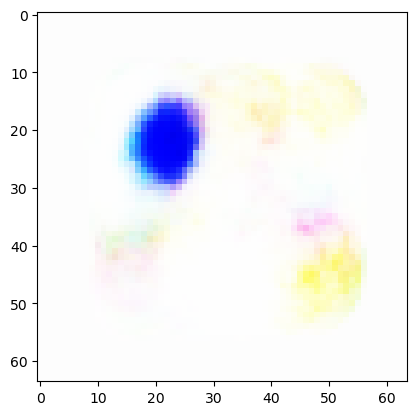

In [10]:
import matplotlib.pyplot as plt

plt.imshow(xhat_idx.detach().cpu().moveaxis(-3, -1).numpy())

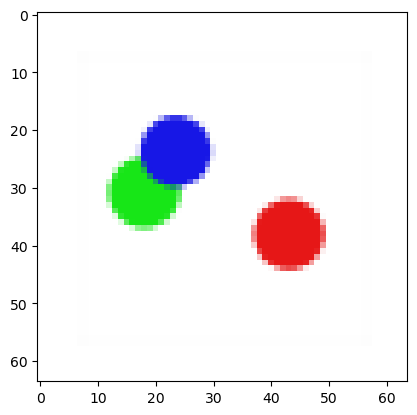

In [11]:
plt.imshow(xs_obs[idx].detach().cpu().moveaxis(-3, -1).numpy())

In [12]:
zs_obs[:10], zhats_obs[:10]

(tensor([[ 0.0230, -0.0789,  0.2484,  0.0852,  0.0434, -0.0741],
         [ 0.0079, -0.4032, -0.2466,  0.4138, -0.3405, -0.3348],
         [ 0.4727, -0.0907,  0.3902,  0.4568,  0.2363,  0.0611],
         [ 0.1415, -0.4528,  0.2029, -0.2911,  0.1031,  0.0519],
         [-0.1390,  0.4046, -0.0070,  0.3928, -0.0344, -0.1818],
         [ 0.3532,  0.4110, -0.4551,  0.0679,  0.1531,  0.2942],
         [-0.3361,  0.3468,  0.3078, -0.3159, -0.1821,  0.0098],
         [ 0.2231, -0.4248, -0.3827, -0.1110, -0.0285, -0.4196],
         [-0.4839, -0.3197, -0.2295,  0.2269,  0.2382, -0.0776],
         [ 0.4814, -0.0623,  0.1986, -0.3796,  0.3802,  0.2991]]),
 tensor([[-1.2891, -4.8242, -2.8673,  2.2205, -1.0572,  4.9621],
         [-5.2812,  3.2960,  2.3989, -2.3841, -1.7807, -5.5625],
         [ 1.5913,  0.0197, -3.7044,  6.7885,  3.8891, -0.3737],
         [ 2.1671,  1.3441,  3.1016,  3.4712, -2.6040,  8.4722],
         [-4.1640, -4.7242, -3.9932,  0.0532, -2.4742, -0.0445],
         [ 6.0027, -0.7